In [28]:
import pandas as pd
import numpy as np
%matplotlib inline

## Feature Analysis

In [30]:
qb = pd.read_csv("data/finalized_data/finalized_QB.csv", index_col=0)
de = pd.read_csv("data/finalized_data/finalized_DEF.csv", index_col=0)
rb = pd.read_csv("data/finalized_data/finalized_RB.csv", index_col=0)
te = pd.read_csv("data/finalized_data/finalized_TE.csv", index_col=0)
wr = pd.read_csv("data/finalized_data/finalized_WR.csv", index_col=0)


### VARIABLES 

#### Very important variables
- week (for time series)
- Outcome
- Score

#### Useless variables
- Season 
- Position (same as file name, except for FB and RB in RB)
- Game Date is probably irrelevant if we have the weeks?
- Also all Years are 2019
- All Games Played are 1
- All Years Played are nan

#### All
- week (1) #integer
- opponent ('PIT') #string
- team ('det') #string
- salary (4500) #integer
- name ('Gabriel, Taylor' or 'Minnesota') #string
- Player Id

#### ALL BUT DEF AND QB
- Longest Reception ('5T' '-8' '--') #string
- Longest Rushing Run ('--' '4T' '9') #string
- Receptions ('--' or '1') #string
- Yards per Reception ('--' '6.0') #string

#### All BUT DEF
- Year (2019) #integer
- Game Date ('09/08') #string
- Home or Away ('Away') #string
- Outcome ('W') #string
- Score ('59 to 10') #string -> x to y --> x - y
- Games Started (1 or 0) #integer
- Rushing Attempts ('7' or '--') #string
- Yards Per Carry ('10.7' or '--') #string
- Rushing TDs ('1' or '--') #string
- Rushing Yards ('32' or '--' ) #string
- Fumbles ('--' or '1') #string
- Fumbles Lost ('--' or '1') #string
- Age (21.) #float?
- Birth Place ('Gainesville , GA') #string
- Birthday ('1/7/1997') #string
- College ('Louisville') #string
- Current Status ('Injured reserve') #string
- Current Team ('Buffalo Bills') #string WHAT IS THE DIFFERENCE BETWEEN THIS AND team???
- Experience ('10th season') #string
- Height (inches) (71.) #float
- High School ('Grand Blanc HS') #string
- High School Location ('Powder Springs, GA' or 'GA') #string
- Number (nan or 17. ) #float
- Weight (lbs) (260.) #float

#### ONLY ON QB 
- Passes Completed ('17' or '--') #string
- Passes Attempted ('17' or '--') #string
- Completion Percentage ('57.7' or '--') #string
- Passing Yards ('308' or '--') #string
- Passing Yards Per Attempt ('9.1' or '--') #string
- TD Passes ('3' or '--') #string
- Ints ('2' or '--') #string
- Sacks ('3' or '--') #string
- Sacked Yards Lost ('17' or '--') #string
- Passer Rating (71.9) #float

### Next Steps

1. Do analysis for the rest of features (CHECK)
2. One-hot-encode the strings and convert all ints to floats
3. Create one feature vector per instance
4. Separate the time variable, and labels
5. Start experimenting with regressors

In [8]:
all_cols = list(qb.columns) + list(rb.columns) + list(wr.columns) + list(te.columns)
all_cols = set(all_cols)
def_cols = list(de.columns)
len(all_cols), def_cols

(46, ['name', 'team', 'opponent', 'points', 'salary', 'week'])

## Data Engineering

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [31]:
### Remove columns
# to_remove = ["Season", "Position", "Game Date", "Year", "Games Played", "Years Played", "Player Id", "name"]
to_remove = ["Season", "Position", "Game Date", "Year", "Games Played", "Years Played"]
targets = [qb, wr, te, rb]

for target in targets:
    target.drop(to_remove, axis=1, inplace=True)

In [32]:
all_numerical_cols = ["week", "salary"]

not_def_numerical_cols = ["Games Started", "Rushing Attempts", "Yards Per Carry", "Rushing TDs", 
                          "Rushing Yards", "Fumbles", "Fumbles Lost", "Age", "Height (inches)", 
                          "Weight (lbs)", "Number"]

not_def_qb_numerical_cols = ["Receptions", "Yards Per Reception"]

only_qb = ["Passes Completed", "Passes Attempted", "Completion Percentage", "Passing Yards", "Sacked Yards Lost",
           "Passing Yards Per Attempt", "TD Passes", "Ints", "Sacks", "Passer Rating"]

In [33]:
# Convert all numerical values to floats
for target in [qb, wr, te, rb, de]:
    for col in all_numerical_cols:
        target[col] = target[col].replace("--", "0").astype("float64")

for target in targets:
    for col in not_def_numerical_cols:
        target[col] = target[col].replace("--", "0").astype("float64")

for target in [wr, te, rb]:
    for col in not_def_qb_numerical_cols:
        target[col] = target[col].replace("--", "0").astype("float64")
        
for col in only_qb:
    qb[col] = qb[col].replace("--", "0").astype("float64")

In [34]:
qb.columns

Index(['Player Id', 'name', 'week', 'Home or Away', 'opponent', 'Outcome',
       'Score', 'Games Started', 'Passes Completed', 'Passes Attempted',
       'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt',
       'TD Passes', 'Ints', 'Sacks', 'Sacked Yards Lost', 'Passer Rating',
       'Rushing Attempts', 'Rushing Yards', 'Yards Per Carry', 'Rushing TDs',
       'Fumbles', 'Fumbles Lost', 'Unnamed: 0.1', 'team', 'points', 'salary',
       'Age', 'Birth Place', 'Birthday', 'College', 'Current Status',
       'Current Team', 'Experience', 'Height (inches)', 'High School',
       'High School Location', 'Number', 'Weight (lbs)'],
      dtype='object')

In [14]:
### Transform data
final_dfs = []

def transform(target):
    # Retrieve columns w/ categorical data
    cat = target.select_dtypes(include=['object']).copy()
    
    #Return df with onehot encoding applied to the columns which are categorical
    one_hot = pd.get_dummies(target, columns=cat.columns)
    one_hot = one_hot.replace(np.nan, 0.0)
    
    return one_hot

qb = transform(qb)
wr = transform(wr)
te = transform(te)
rb = transform(rb)

In [15]:
# Turn into X and Y
qb_X = qb.drop("points", axis=1).values
qb_y = qb["points"].values

In [16]:
qb_X

array([[ 1.,  1., 17., ...,  0.,  0.,  0.],
       [ 5.,  1., 19., ...,  0.,  0.,  0.],
       [ 7.,  1.,  9., ...,  0.,  0.,  0.],
       ...,
       [ 4.,  1., 18., ...,  0.,  0.,  0.],
       [ 5.,  1., 28., ...,  0.,  0.,  0.],
       [ 7.,  1., 31., ...,  0.,  0.,  0.]])

In [12]:
len(qb_X)

103

In [13]:
# Scale/normalize values
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(qb_X)
# Apply transform to both the training set and the test set.
qb_X = scaler.transform(qb_X)

In [14]:
len(qb_X)

103

In [15]:
# Perform Grid Search on PCA
pca = PCA(n_components=0.95)
pca.fit(qb_X)
trans_qb_X = pca.transform(qb_X)

# param_grid = {
#     'n_components': [20, 35, 50, 65, 0.95]
# }
# search = GridSearchCV(pca, param_grid, n_jobs=-1)
# search.fit(qb_X, qb_y)
# print("Best parameter (CV score=%0.3f):" % search.best_score_)
# print(search.best_params_)


In [16]:
len(trans_qb_X[0])

72

## Regression

In [381]:
# Apply simple Ridge Regression for testing purposes
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [382]:
X_train, X_test, y_train, y_test=train_test_split(qb_X, qb_y, test_size=0.2,random_state=69420)

In [383]:
ridge = Ridge()
param_grid = {
    'alpha': [0.01, 0.1, 0.2, 1, 10, 100]
}
search = GridSearchCV(ridge, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

/Users/dafirebanks/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameter (CV score=0.611):
{'alpha': 10}


In [386]:
ridge_opt = Ridge(alpha=10, random_state=69420)
ridge_opt.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=69420, solver='auto', tol=0.001)

In [387]:
preds = ridge_opt.predict(X_test)

In [63]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [406]:
max(y_test), min(y_test)

(28.9, 1.16)

In [393]:
mean_absolute_error(y_test, preds)

4.002270756503693

In [394]:
mean_squared_error(y_test, preds)

25.827383540169226

In [395]:
r2_score(y_test, preds)

0.5532005272426592

In [401]:
np.sqrt(mean_squared_error(y_test, preds))

5.082064889409542

In [405]:
len(X_test), len(y_test), len(preds)

(21, 21, 21)

In [407]:
y_test, preds

(array([17.52, 28.9 , 24.66,  9.3 , 16.72,  1.16,  9.08,  8.98, 15.44,
        20.56, 24.92, 28.18,  3.58, 16.78, 21.54, 20.44, 14.44, 13.46,
        24.34, 12.92,  7.86]),
 array([18.9703144 , 21.49256999, 19.0090774 , 11.59092028, 16.48571005,
         9.66636725, 11.75678144, 11.09221383, 13.90925573, 23.38854914,
        17.32970451, 18.61086023,  4.07068359, 17.5215175 , 23.05563577,
        15.27304844, 20.9016149 , 17.46097512, 13.7700557 , 11.51462349,
         9.70701819]))

## Time Series Regression

In [44]:
# Source: http://mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/

0. Remove all other features, leaving only week and score per player

In [48]:
# Remove features
time_qb = qb[['week', 'points', 'Player Id']]

# Sort by week and ID
time_qb = time_qb.sort_values(['week', 'Player Id'])
time_qb.head()

,week,points,Player Id
93,1,12.92,aaronrodgers/2506363
22,1,20.72,andydalton/2495143
67,1,27.20,casekeenum/2532888
61,1,-0.82,danieljones/2562299
30,1,14.84,elimanning/2505996


1. Some feature engineering on scores

In [55]:
time_qb2 = time_qb.copy()
time_qb2['Last_Week_Points'] = time_qb2.groupby(['Player Id'])['points'].shift()
time_qb2['Last_Week_Diff'] = time_qb2.groupby(['Player Id'])['Last_Week_Points'].diff()
time_qb2 = time_qb2.dropna()
time_qb2.head()

,week,points,Player Id,Last_Week_Points,Last_Week_Diff
24,4,4.64,andydalton/2495143,18.06,-2.66
17,5,21.16,gardnerminshew/2562796,16.72,0.60
86,5,18.90,jaredgoff/2555334,16.16,5.72
92,5,18.46,joshallen/2560955,22.22,4.26
8,5,32.90,mattryan/310,23.46,2.90


In [60]:
time_qb['week'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8])

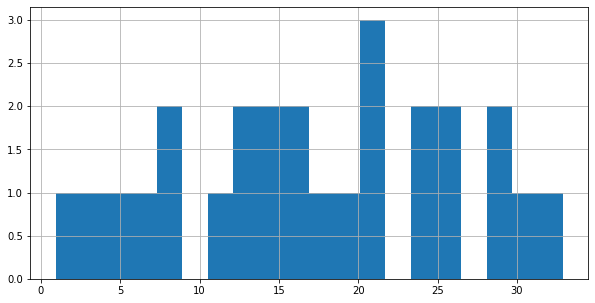

In [59]:
time_qb2['points'].hist(bins=20, figsize=(10,5))

In [107]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [96]:
# Try changing player id stuff?
time_qb['Player Id'] = time_qb['Player Id'].str.extract('(\d+)', expand=False).astype(int)

In [92]:
# Baseline model? We should look into this later
mean_error = []
for week in range(4, 9):
    train = time_qb2[time_qb2['week'] < week]
    val = time_qb2[time_qb2['week'] == week]
    
    p = val['Last_Week_Points'].values
    
    error = rmsle(val['points'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 4 - Error 1.21771
Week 5 - Error 0.70761
Week 6 - Error 1.66017
Week 7 - Error 0.62166
Week 8 - Error 0.69810
Mean Error = 0.98105


In [93]:
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [108]:
# Try Random Forests?
mean_error = []
for week in range(2, 9):
    train = time_qb[time_qb['week'] < week]
    val = time_qb[time_qb['week'] == week]
    
    xtr, xts = train.drop(['points'], axis=1), val.drop(['points'], axis=1)
    ytr, yts = train['points'].values, val['points'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=69420)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 2 - Error 10.56873
Week 3 - Error 7.87561
Week 4 - Error 9.84751
Week 5 - Error 11.80581
Week 6 - Error 10.64140
Week 7 - Error 9.19862
Week 8 - Error 11.54118
Mean Error = 10.21127


In [ ]:
## time_qb3 = time_qb.copy()
time_qb3['Last_Week_Points'] = time_qb3.groupby(['Player Id'])['points'].shift()
time_qb3['Last_Week_Diff'] = time_qb3.groupby(['Player Id'])['Last_Week_Points'].diff()
time_qb3['Last-1_Week_Points'] = time_qb3.groupby(['Player Id'])['points'].shift(2)
time_qb3['Last-1_Week_Diff'] = time_qb3.groupby(['Player Id'])['Last-1_Week_Points'].diff()
time_qb3 = time_qb3.dropna()
time_qb3.head()

In [103]:
# Try Random Forests?
mean_error = []
for week in range(7, 9):
    train = time_qb3[time_qb3['week'] < week]
    val = time_qb3[time_qb3['week'] == week]
    
    xtr, xts = train.drop(['points'], axis=1), val.drop(['points'], axis=1)
    ytr, yts = train['points'].values, val['points'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=69420)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 7 - Error 0.26306
Week 8 - Error 0.84139
Mean Error = 0.55223


In [2]:
qb_X

NameError: name 'qb_X' is not defined

## Vector Auto Regression

In [110]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [19]:
import matplotlib.pyplot as plt

In [45]:
wr['Player Id'].unique()

array(['t.y.hilton/2532865', 'tavonaustin/2539336',
       'hunterrenfrow/2562712', 'dariusslayton/2562736',
       'kekecoutee/2561029', 'calvinridley/2560854',
       'diontaespencer/2550734', 'marqiselee/2543475',
       'ray-raymccloud/2560801', 'malikturner/2561671',
       'isaiahmckenzie/2558129', 'allenhurns/2550353',
       'willfuller/2555346', 'allenlazard/2560787',
       'courtlandsutton/2560888', 'vyncintsmith/2561427',
       'jakekumerow/2553548', 'andreroberts/497320',
       'sethroberts/2550597', 'laquontreadwell/2555214',
       'tylerboyd/2555466', 'jamisoncrowder/2552415',
       'gunnerolszewski/2563329', 'joshgordon/2537931',
       'robertdavis/2558254', 'sterlingshepard/2555295',
       'jujusmith-schuster/2558149', 'khadarelhodge/2561653',
       'tajaesharpe/2555317', 'mackhollins/2558262',
       'parriscampbell/2562495', 'd.j.moore/2560813',
       'michaelgallup/2560735', 'jarvislandry/2543488',
       'albertwilson/2550272', 'robbyanderson/2556462',
    

In [68]:
# wr[wr['Player Id'] == 'd.j.chark/2561018']

wr.groupby('week').count()

# wr['Player Id'].max()

,Player Id,name,Home or Away,opponent,Outcome,Score,Games Started,Receptions,Receiving Yards,Yards Per Reception,...,Birthday,College,Current Status,Current Team,Experience,Height (inches),High School,High School Location,Number,Weight (lbs)
week,,,,,,,,,,,,,,,,,,,,,
1.0,60,60,60,60,60,60,60,60,60,60,...,60,60,60,58,60,60,58,58,56,60
2.0,67,67,67,67,67,67,67,67,67,67,...,67,67,67,63,67,67,63,63,63,67
3.0,44,44,44,44,44,44,44,44,44,44,...,44,44,44,43,44,44,42,42,41,44
4.0,54,54,54,54,54,54,54,54,54,54,...,54,54,54,53,54,54,53,53,50,54
5.0,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,60,60,60,60
6.0,35,35,35,35,35,35,35,35,35,35,...,35,35,35,34,35,35,34,34,33,35
7.0,60,60,60,60,60,60,60,60,60,60,...,60,60,60,60,60,60,59,59,58,60
8.0,41,41,41,41,41,41,41,41,41,41,...,41,41,41,41,41,41,40,40,41,41


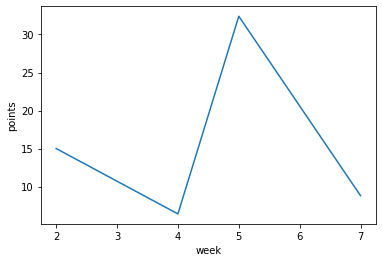

In [58]:
alt = wr[wr['Player Id'] == 'd.j.chark/2561018']
altered = alt[['week', 'points']]
altered = altered.set_index(['week'])
plt.xlabel('week')
plt.ylabel('points')
plt.plot(altered)

In [69]:
altered

,points
week,
2.0,15.0
4.0,6.4
5.0,32.4
7.0,8.8
